Let's explore whether LLM-derived embeddings of stock names / symbols can predict extra information about said stocks, like sector or industry.

Start by importing the necessary modules.

In [62]:
import collections
import itertools

import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas import option_context
from sentence_transformers import SentenceTransformer
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
from IPython.display import display


Some utilities:

In [63]:
def prepare_df(df):
  df['Sector'].fillna('Unknown', inplace=True)

  df['Industry'].fillna('Unknown', inplace=True)

  df['Market Cap'].fillna(0, inplace=True)

  # remove Unknown sector or industry
  df = df[df['Sector'] != 'Unknown']
  df = df[df['Industry'] != 'Unknown']

  df.sort_values(by=['Market Cap'], inplace=True, ascending=False)

  return df


def compute_embeddings(model, strings):
  return model.encode(strings)

A basic logistic regression classifier.

In [64]:
class LogisticRegression(torch.nn.Module):
  def __init__(self, input_dim, n_classes, class_weights=None):
    super(LogisticRegression, self).__init__()

    if class_weights is None:
      class_weights = torch.ones(n_classes)

    class_weights = class_weights / class_weights.sum()

    self.class_weights = class_weights.type(torch.FloatTensor)

    self.linear = torch.nn.Linear(input_dim, n_classes)

  def forward(self, x):
    return self.linear(x)

Utilities to train the model

In [65]:
# datatypes for train/test results
TrainResult = collections.namedtuple(
    'TrainResult', ['train_losses', 'test_losses', 'accuracy', 'accuracy_top5', 'best_accuracy', 'best_accuracy_top5', 'best_idx_correct'])
TestResult = collections.namedtuple('TestResult', ['loss', 'accuracy', 'accuracy_top5', 'idx_correct'])


def train(model, train_dataloader, test_dataloader, n_epochs=20, quiet=False, weight_decay=1e-5):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
  loss_fn = torch.nn.CrossEntropyLoss(weight=model.class_weights)

  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=4, verbose=False)

  # lr_scheduler = None

  train_losses = []

  test_losses = []

  accuracy = []
  accuracy_top5 = []

  best_accuracy = best_accuracy_top5 = 0

  best_idx_correct = None

  for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, lr_scheduler)

    test_result = test_epoch(model, test_dataloader, loss_fn)

    train_losses.append(train_loss)

    test_losses.append(test_result.loss)

    accuracy.append(test_result.accuracy)

    accuracy_top5.append(test_result.accuracy_top5)

    if test_result.accuracy > best_accuracy:
      best_accuracy = test_result.accuracy

      best_idx_correct = test_result.idx_correct

    if test_result.accuracy_top5 > best_accuracy_top5:
      best_accuracy_top5 = test_result.accuracy_top5

    if not quiet:
      print(f'Epoch {epoch + 1}/{n_epochs} | Train loss: {train_loss:.4f} | Test loss: {test_result.loss:.4f} | Test accuracy: {test_result.accuracy:.4f} | Test accuracy top 5: {test_result.accuracy_top5:.4f}')

  return TrainResult(train_losses, test_losses, accuracy, accuracy_top5, best_accuracy, best_accuracy_top5, best_idx_correct)


def train_epoch(model, train_dataloader, optimizer, loss_fn, lr_scheduler):
  losses = []

  model.train(True)

  for batch in train_dataloader:
    optimizer.zero_grad()

    X, Yc = batch

    Y = model(X)

    loss = loss_fn(Y, Yc)

    loss.backward()

    optimizer.step()

    if lr_scheduler is not None:
      lr_scheduler.step()

    losses.append(loss.item())

  return np.mean(losses)

def test_epoch(model, test_dataloader, loss_fn):
  model.eval()

  with torch.no_grad():
    losses = []

    total_correct = 0

    total_correct_top5 = 0

    idx_correct = []

    for batch in test_dataloader:
      X, Yc = batch

      Y = model(X)

      total_correct += (torch.argmax(Y, dim=1) == Yc).sum().item()

      total_correct_top5 += (torch.topk(Y, k=5, dim=1)[1] == Yc.view(-1, 1)).sum().item()

      loss = loss_fn(Y, Yc)

      losses.append(loss.item())

      Z = torch.argsort(Y, dim=1, descending=True)
      
      W = [Z[i, :].tolist().index(Yc[i].item()) for i in range(len(Yc))]

      idx_correct.extend(W)

    accuracy = total_correct / len(test_dataloader.dataset)

    accuracy_top5 = total_correct_top5 / len(test_dataloader.dataset)

    return TestResult(np.mean(losses), accuracy, accuracy_top5, idx_correct)


Utility to run experiments.

In [66]:
def run_experiment(
    model_class, embedding_model, df, x_column="Name", string_builder=None, 
    perc=None, n=None, y_column='Sector', n_epochs=20, quiet=False, quiet_train=True, plot=True):
  if perc is not None:
    n = int(len(df) * perc)

  if n is not None:
    n = min(n, len(df))

  if string_builder is None:
    string_builder = lambda df: df[x_column].tolist()
    
  df = df.head(n)

  df = df.sample(frac=1, random_state=42).reset_index(drop=True)

  strings = string_builder(df)

  print("example strings:", strings[:10])

  embeddings = embedding_model.encode(strings)  

  classes = df[y_column].unique().tolist()

  # add column with class index
  df['class'] = df[y_column].apply(lambda x: classes.index(x))

  X = embeddings
  Yc = np.array(df['class'].tolist())

  class_value_counts = df['class'].value_counts() 

  class_weights = torch.tensor([1 / class_value_counts[i] for i in range(len(classes))])

  model = model_class(input_dim=X.shape[1], n_classes=len(classes), class_weights=class_weights)

  # make dataset
  dataset = TensorDataset(torch.tensor(X), torch.tensor(Yc))

  # split dataset 
  train_size = int(0.7 * len(dataset))
  test_size = len(dataset) - train_size

  log_market_cap = np.log((df[train_size:]['Market Cap'] + 1e-6).tolist())

  # split the dataset into train and test datasets
  train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
  test_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))

  test_df = df[train_size:].copy()

  # make dataloaders
  train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=BATCH_SIZE)
  test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                batch_size=BATCH_SIZE)

  # train model
  result = train(model, train_dataloader, test_dataloader, n_epochs=n_epochs, quiet=quiet_train)

  if not quiet:
    # print a sample of test names and symbols and the index of their correct answer
    test_df['best_idx_correct'] = result.best_idx_correct

    with option_context('display.max_colwidth', 50):
      display(test_df[['Name', 'Symbol', y_column, 'best_idx_correct']].sample(n=20))
    

  print("Accuracy: {:.4f}, Accuracy top 5: {:.4f}".format(result.best_accuracy, result.best_accuracy_top5))

  if plot:
    # plot 2 figures
    # 1. train and test losses
    # 2. scatter plot of log of market cap vs index of correct answer
    figure, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].plot(result.train_losses, label='train')
    axes[0].plot(result.test_losses, label='test')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(result.accuracy, label='accuracy')
    axes[1].plot(result.accuracy_top5, label='accuracy top 5')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Test accuracy')
    axes[1].legend()

    axes[2].scatter(log_market_cap, result.best_idx_correct)
    axes[2].set_xlabel('Log of market cap')
    axes[2].set_ylabel('Index of correct answer')
    axes[2].set_title('Log of market cap vs index of correct answer')

    plt.show()

  return result

Load data.

In [67]:
df0 = pd.read_csv('data/nasdaq.csv.gz')

df1 = pd.read_csv('data/nyse.csv.gz')

df = pd.concat([df0, df1], ignore_index=True)

df = prepare_df(df)

print(df.Sector.value_counts())

print(df.Industry.value_counts())

Sector
Finance                   2496
Consumer Discretionary    1591
Health Care               1334
Technology                 976
Industrials                848
Real Estate                467
Energy                     326
Utilities                  286
Consumer Staples           200
Basic Materials            155
Telecommunications         124
Miscellaneous               65
Name: count, dtype: int64
Industry
Biotechnology: Pharmaceutical Preparations         661
Blank Checks                                       460
Major Banks                                        391
Real Estate Investment Trusts                      382
Investment Managers                                349
                                                  ... 
Tools/Hardware                                       2
Miscellaneous                                        2
General Bldg Contractors - Nonresidential Bldgs      2
Tobacco                                              2
Diversified Electronic Products     

Our constants.

In [68]:
BATCH_SIZE = 64

N_EPOCHS = 200

# EMBEDDINGS_MODEL = 'bert-base-nli-mean-tokens'
EMBEDDINGS_MODEL = 'all-mpnet-base-v2'


Load embedding model.

In [69]:
embedding_model = SentenceTransformer(EMBEDDINGS_MODEL)

In [70]:
model_class = LogisticRegression

Run an experiment. Classify by sector using name embeddings.

In [72]:
run_experiment(model_class, embedding_model, df, x_column="Name", y_column="Sector", perc=0.9, n_epochs=N_EPOCHS, quiet=False, plot=True)

example strings: ['Spectrum Brands Holdings Inc. Common Stock', 'Cohen & Steers Inc Common Stock', 'Mainz Biomed N.V. Ordinary Shares', 'Bit Brother Limited Class A Ordinary Shares', 'AgriFORCE  Growing Systems Ltd. Common Shares', 'Blackrock MuniYield Michigan Quality Fund Inc. Common Stock', 'Brookfield Business Partners L.P. Limited Partnership Units ', 'SoundHound AI Inc. Warrant', 'Invivyd Inc. Common Stock', 'Revolve Group Inc. Class A Common Stock']


Also, classify industry by name embedding.

In [ ]:
run_experiment(model_class, embedding_model, df, x_column="Name", y_column="Industry", perc=0.9, n_epochs=N_EPOCHS, quiet=False, plot=True)

Likewise, let's predict sector and industry, but using just the symbol.

In [ ]:
run_experiment(model_class, embedding_model, df, x_column="Symbol", y_column="Sector", perc=0.9, n_epochs=N_EPOCHS, quiet=False)

run_experiment(model_class, embedding_model, df, x_column="Symbol", y_column="Industry", perc=0.9, n_epochs=N_EPOCHS, quiet=False)

As you can see, predicting from symbol is much harder, which gives us a clue that the LLM extract clues from the actual words in the name of a company (for example, Advanced Micro Devices says a lot about what sector the company is in). However, it's clear that the model has some clues about the sector/industry that symbol is associated with, as the accuracy and top5-accuracy are both much higher that random chance.

Let's dive a bit deeper and check the index of the correct answer in the prediction for a selection of companies in the test set. Remember, always check your data and results, it can give valuable clues.

Let's now run some experiments. 

First up, can we enhance the string that we pass to the embedding model so that we improve the classification performance. In other words, can we do prompt engineering? Conversely, can we modify the input string (while still containing the original name/symbol unchanged) that we degrade the classification performance.

For our improved prompt we will use one that specifies what we're looking for:

In [ ]:
def better_prompt_name(df):
  PROMPT = "The sector that company {name} belongs to is:"

  return df['Name'].apply(lambda x: PROMPT.format(name=x)).tolist()

def better_prompt_symbol(df):
  PROMPT = "The sector that company with symbol {symbol} belongs to is:"

  return df['Symbol'].apply(lambda x: PROMPT.format(symbol=x)).tolist()

Whereas for our degraded prompt we will explore two options:
* One that specifies something that we're not looking for
* One that add random strings at the beginning and end of the input string

In [ ]:
def make_bad_prompt_1(column):
  def foo(df):
    PROMPT = "I'd like an ice cream with {value} flavor"

    return df[column].apply(lambda x: PROMPT.format(value=x)).tolist()

  return foo

def random_string(max_n=20):
  n = np.random.randint(1, max_n)

  return ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz '), n))

def make_bad_prompt_2(column):
  def foo(df):
    PROMPT = "{prefix}{value}{suffix}"

    return df[column].apply(lambda x: PROMPT.format(prefix=random_string(), value=x, suffix=random_string())).tolist()

  return foo

Run experiments.

In [ ]:

def run_prompt_experiment(df, x_column, y_column, string_builder, variation):
  print("Running experiment {} -> {} ({})".format(x_column, y_column, variation))

  result = run_experiment(model_class, embedding_model, df, x_column=x_column, y_column=y_column, string_builder=string_builder, perc=.9, n_epochs=N_EPOCHS, quiet=True, plot=False)

  return {
    'X': x_column,
    'Y': y_column,
    'variation': variation,
    'accuracy': result.best_accuracy,
    'accuracy_top5': result.best_accuracy_top5,
  }


In [ ]:
data = [
  run_prompt_experiment(df, "Name", "Sector", None, "Default prompt"),
  run_prompt_experiment(df, "Name", "Industry", None, "Default prompt"),
  run_prompt_experiment(df, "Symbol", "Sector", None , "Default prompt"),
  run_prompt_experiment(df, "Symbol", "Industry", None , "Default prompt"),

  run_prompt_experiment(df, "Name", "Sector", better_prompt_name, "Better prompt"),
  run_prompt_experiment(df, "Name", "Industry", better_prompt_name, "Better prompt"),
  run_prompt_experiment(df, "Symbol", "Sector", better_prompt_symbol , "Better prompt"),
  run_prompt_experiment(df, "Symbol", "Industry", better_prompt_symbol , "Better prompt"),

  run_prompt_experiment(df, "Name", "Sector", make_bad_prompt_1("Name"), "Bad prompt 1"),
  run_prompt_experiment(df, "Name", "Industry", make_bad_prompt_1("Name"), "Bad prompt 1"),
  run_prompt_experiment(df, "Symbol", "Sector", make_bad_prompt_1("Symbol") , "Bad prompt 1"),
  run_prompt_experiment(df, "Symbol", "Industry", make_bad_prompt_1("Symbol") , "Bad prompt 1"),

  run_prompt_experiment(df, "Name", "Sector", make_bad_prompt_2("Name"), "Bad prompt 2"),
  run_prompt_experiment(df, "Name", "Industry", make_bad_prompt_2("Name"), "Bad prompt 2"),
  run_prompt_experiment(df, "Symbol", "Sector", make_bad_prompt_2("Symbol") , "Bad prompt 2"),
  run_prompt_experiment(df, "Symbol", "Industry", make_bad_prompt_2("Symbol") , "Bad prompt 2"),
]

df_exp1 =pd.DataFrame.from_dict(data)

In [ ]:
df1_name = df_exp1[df_exp1['X'] == 'Name'].sort_values(by=['Y'])
df1_symbol = df_exp1[df_exp1['X'] == 'Symbol'].sort_values(by=['Y'])

In [ ]:
def style_table(df):
  return df.style \
    .hide(axis=0) \
    .background_gradient(cmap='Blues', axis=1) \
    .highlight_max(subset=['accuracy', 'accuracy_top5'], color='orange')


In [ ]:
style_table(df1_name)

In [ ]:
style_table(df1_symbol)

Experiment #2: Let's see if we can improve the classification performance by using a more complex model. We will use a simple feed-forward neural network with a single hidden layer.

In [ ]:
class MLPClassifier(torch.nn.Module):
  def __init__(self, input_dim, n_classes, class_weights=None):
    super(MLPClassifier, self).__init__()

    if class_weights is None:
      class_weights = torch.ones(n_classes)

    class_weights = class_weights / class_weights.sum()

    self.class_weights = class_weights.type(torch.FloatTensor)

    self.linear1 = torch.nn.Linear(input_dim, 128)
    self.linear2 = torch.nn.Linear(128, 64)
    self.linear3 = torch.nn.Linear(64, n_classes)

  def forward(self, x):
    x = torch.nn.functional.relu(self.linear1(x))
    x = torch.nn.functional.relu(self.linear2(x))
    x = self.linear3(x)
    return x

In [ ]:
def run_experiment_2(df, model_class, x_column, y_column):
  cname = model_class.__name__
  print("Running experiment {} -> {} ({})".format(x_column, y_column, cname))

  result = run_experiment(model_class, embedding_model, df, x_column=x_column, y_column=y_column, perc=.9, n_epochs=N_EPOCHS, quiet=True, plot=False)

  return {
    'X': x_column,
    'Y': y_column,
    'variation': cname,
    'accuracy': result.best_accuracy,
    'accuracy_top5': result.best_accuracy_top5,
  }

In [ ]:
data = [
  run_experiment_2(df, LogisticRegression, "Name", "Sector"),
  run_experiment_2(df, LogisticRegression, "Name", "Industry"),
  run_experiment_2(df, LogisticRegression, "Symbol", "Sector"),
  run_experiment_2(df, LogisticRegression, "Symbol", "Industry"),

  run_experiment_2(df, MLPClassifier, "Name", "Sector"),
  run_experiment_2(df, MLPClassifier, "Name", "Industry"),
  run_experiment_2(df, MLPClassifier, "Symbol", "Sector"),
  run_experiment_2(df, MLPClassifier, "Symbol", "Industry"),
]

df_exp2 = pd.DataFrame.from_dict(data)

In [ ]:
df_exp2

Experiment #3: how do various embedding models do? We will run our experiment with a number of models supported by the SentenceTransformers library.

In [8]:
def run_experiment_3(df, embedding_model_name, x_column, y_column):
  print("Running experiment {} -> {} ({})".format(x_column, y_column, embedding_model_name))

  embedding_model = SentenceTransformer(embedding_model_name)

  result = run_experiment(LogisticRegression, embedding_model, df, x_column=x_column, y_column=y_column, perc=.9, n_epochs=N_EPOCHS, quiet=True, plot=False)

  return {
    'X': x_column,
    'Y': y_column,
    'variation': embedding_model_name,
    'accuracy': result.best_accuracy,
    'accuracy_top5': result.best_accuracy_top5,
  }

In [ ]:
embedding_model_names = [
  'all-mpnet-base-v2',
  'all-distilroberta-v1',
  'multi-qa-mpnet-base-dot-v1',
  'all-MiniLM-L12-v2',
  'paraphrase-multilingual-mpnet-base-v2',
]


data = [
  run_experiment_3(df, embedding_model_name, x_column, y_column)
  for embedding_model_name in embedding_model_names
  for x_column in ['Name', 'Symbol']
  for y_column in ['Sector', 'Industry']
]

df_exp3 = pd.DataFrame.from_dict(data)

In [61]:
df_exp3

,X,Y,variation,accuracy,accuracy_top5
0,Name,Sector,all-mpnet-base-v2,0.572860,0.912735
1,Name,Industry,all-mpnet-base-v2,0.400000,0.643006
2,Symbol,Sector,all-mpnet-base-v2,0.271399,0.759499
3,Symbol,Industry,all-mpnet-base-v2,0.217954,0.375365
4,Name,Sector,all-distilroberta-v1,0.544050,0.913987
5,Name,Industry,all-distilroberta-v1,0.375783,0.604593
6,Symbol,Sector,all-distilroberta-v1,0.242589,0.756576
7,Symbol,Industry,all-distilroberta-v1,0.170772,0.324843
8,Name,Sector,multi-qa-mpnet-base-dot-v1,0.605428,0.935699
9,Name,Industry,multi-qa-mpnet-base-dot-v1,0.502714,0.687265


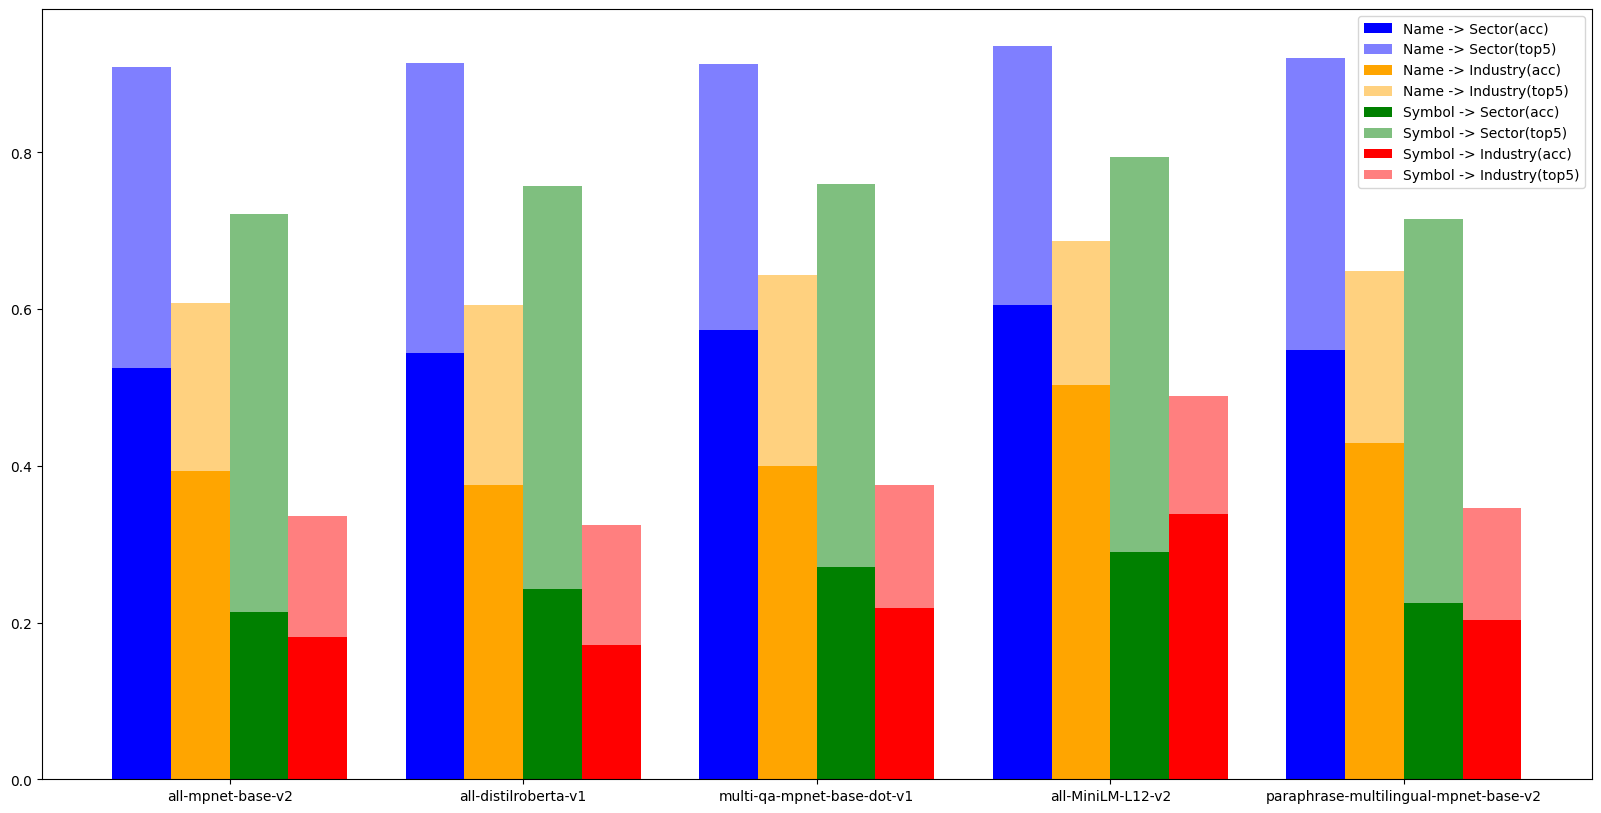

In [60]:

width = 0.2

x = np.arange(len(df_exp3['variation'].unique()))

colors = ['blue', 'orange', 'green', 'red', 'purple']

variations = df_exp3['variation'].unique()

fig, ax = plt.subplots(1, figsize=(20, 10))

for i, (c, (x_column, y_column)) in enumerate(zip(colors, itertools.product(['Name', 'Symbol'], ['Sector', 'Industry']))):
  dfX = df_exp3[(df_exp3['X'] == x_column) & (df_exp3['Y'] == y_column)].sort_values(by=['variation'])

  label = '{x_column} -> {y_column}(acc)'.format(x_column=x_column, y_column=y_column)

  ax.bar(x + i * width, dfX['accuracy'], width=width, bottom=0, color=c, alpha=1., label=label)

  label2 = '{x_column} -> {y_column}(top5)'.format(x_column=x_column, y_column=y_column)
  ax.bar(x + i * width, dfX['accuracy_top5'], width=width, bottom=0, color=c, label=label2, alpha=0.5)

ax.legend()
ax.set_xticks(x - width/2 + width * (len(variations) - 1) / 2, variations)
plt.show()